# Analysis of confout.pdb files

This is to check progress of the string simulations in a "not CV" space. IE we can look at gate COM, salt bridge progress, sugar coordination etc. 

The purpose of this is to check integrity of the simulations. Ideally we will compare 2 - 4 confout files at a time. This way you can see if there is some average drift or instabilities happening potentially

#### input:
Use simulations parsed by `combine_confout.sh` which will take the `.gro` files from the `md/(#iteration)/restrained/confout.gro` and save only the protein. Then concatenate each bead output from this to have one continuous 'trajectory' which is # beads long

In [10]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

In [11]:
indir = '../confout_files/measure_per_iteration'
traj = 'efflux_demyst_CV'
#traj = 'influx_BFRU_demyst_CV'

### here you put which iterations you want to compare
if traj == 'efflux_demyst_CV':
    iterations = [27, 60, 80, 100,150]  #these are the iterations I have so far. Don't have to change each time, just add more
elif traj == 'influx_BFRU_demyst_CV':
    iterations = [10,25,100,150]

universe_list = []
for iteration in iterations:
    universe_list.append(mda.Universe('%s/%s.%i.string.pdb' %(indir, traj, iteration) ))
    


# Gate COM detection

In [12]:
from MDAnalysis.analysis import distances

def make_gate_arr(md_uni, gate_EC, gate_IC):
    gate_EC_dists = []
    gate_IC_dists = []
    
    for timestep in md_uni.trajectory:
        tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
        tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
        tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
        tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    


        gate_EC_dists.append(float(distances.distance_array(tm1, tm7)))
        gate_IC_dists.append(float(distances.distance_array(tm4, tm10)))

    return gate_EC_dists, gate_IC_dists

In [13]:
def make_gate_plot(EC_list, IC_list, label_list, figname = None):
    figsize = (13, 6)
    markersize = 8
    linewidth = 3
    lim = (8,17)
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize = figsize)

    ## ec gate
    for n, EC in enumerate(EC_list):
        ax1.plot(EC, label = label_list[n], color = colors[n], linewidth = linewidth)
    ax1.set_title("Extracellular gate")
    ax1.set_xlim(0)
    #ax1.set_ylim(ylim)
    ax1.set_ylabel('Distance (A)')


    ## ic gate
    for n, IC in enumerate(IC_list):
        ax2.plot(IC, label = label_list[n], color = colors[n], linewidth = linewidth)
    ax2.set_title("Intracellular gate")
    ax2.set_xlim(0) 
    #ax2.set_ylim(ylim)
    ax2.set_xlabel('Time (ns)')
    ax2.set_ylabel('Distance (A)')

    
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
              fancybox=True, shadow=True, ncol=2)

    if figname:
        plt.savefig('../images_figs/%s.png' %figname, dpi = 200)

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:690: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)


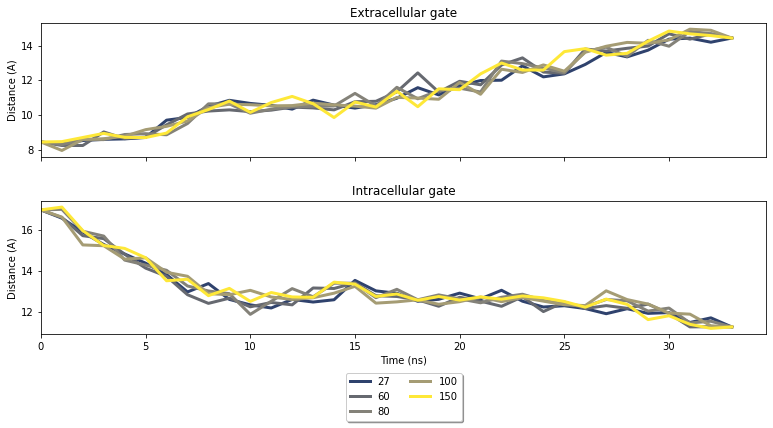

In [6]:
cmap = plt.cm.get_cmap('cividis')
colors = cmap(np.array(iterations) / max(iterations))[:,:-1]

EC_list = []
IC_list = []

for simulation in universe_list:
    EC, IC = make_gate_arr(simulation, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])
    EC_list.append(EC)
    IC_list.append(IC)
    
make_gate_plot(EC_list = EC_list, IC_list= IC_list, label_list = iterations)

### Can also assess std of each bead to see if there are problem regions or highly variable states

Here I also make a dot for the gate COM of the initial atomistic trajectories (which were targets in the steered MD) and plot it ***APPROXIMATELY*** at the position in the trajectory where it corresponds to

In [7]:
refs = ['IN.303ns.gro', 'IN-OCC.150ns.gro', 'OCC.370ns.gro', 'OUT-OCC.290ns.gro', 'OUT.520ns.gro']
if 'influx' in traj:
    refs = refs[::-1]   # if we are looking at influx sims, refs needs to be in the OPPOSITE order!! 

ref_universe = []
for ref in refs:
    ref_universe.append(mda.Universe('../../../steered/analysis/ref_atom_sim/%s' %ref))
    
ref_EC = []
ref_IC = []

for simulation in ref_universe:
    EC, IC = make_gate_arr(simulation, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])
    ref_EC.append(EC)
    ref_IC.append(IC)

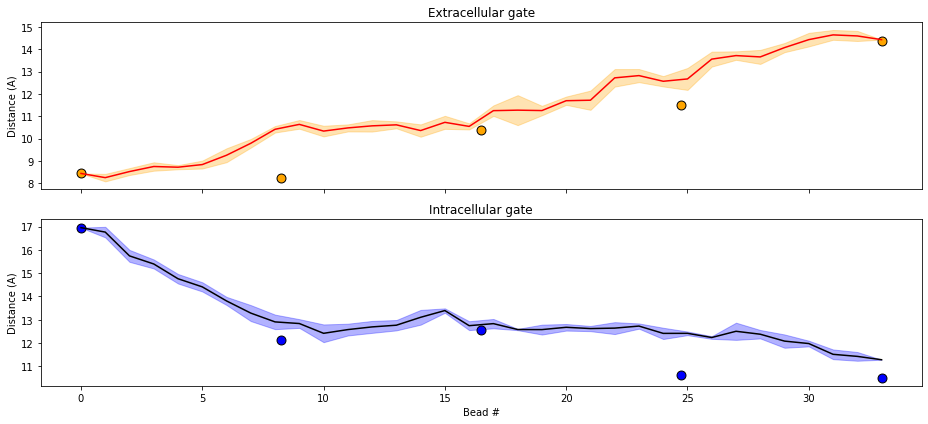

In [8]:
figsize = (13, 6)
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, figsize = figsize)
markersize = 80

EC_std = np.std(np.array(EC_list), axis = 0)
IC_std = np.std(np.array(IC_list), axis = 0)

EC_mean = np.mean(np.array(EC_list), axis = 0)
IC_mean = np.mean(np.array(IC_list), axis = 0)

ref_locs = np.linspace(0, 33, num = len(ref_EC))

alpha = 0.3

ax1.plot(EC_mean, color = 'red')
ax1.fill_between(range(len(EC_mean)), (EC_mean + EC_std), (EC_mean - EC_std), alpha = alpha, color = 'orange')
ax1.scatter(ref_locs, ref_EC, color = 'orange', s = markersize, edgecolor = 'black')
ax1.set_title("Extracellular gate")
ax1.set_ylabel('Distance (A)')


ax2.plot(IC_mean, color = 'black')
ax2.fill_between(range(len(IC_mean)), (IC_mean + IC_std), (IC_mean - IC_std), alpha = alpha, color = 'blue')
ax2.scatter(ref_locs, ref_IC, color = 'blue', s = markersize, edgecolor = 'black')
ax2.set_title("Intracellular gate")
ax2.set_xlabel('Bead #')
ax2.set_ylabel('Distance (A)')

plt.tight_layout()

# Can also compare each CV method

Here you can compare `efflux_demyst` to `efflux_gate` at a certain iteration to see how deviant they are from each other. You also have the option to compare this to `influx_demyst` 

In [77]:
iteration = 150

indir = '../confout_files/measure_per_iteration'
#traj_l = ['efflux_demyst_CV', 'efflux_gate_CV', 'influx_BFRU_demyst_CV']
traj_l = ['efflux_demyst_CV', 'influx_BFRU_demyst_CV']
universe_list = []
for traj in traj_l:
    universe_list.append(mda.Universe('%s/%s.%i.string.pdb' %(indir, traj, iteration) ))    

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/topology/base.py:203: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  residx = np.zeros_like(criteria[0], dtype=np.int)


Normal plot of gate dists

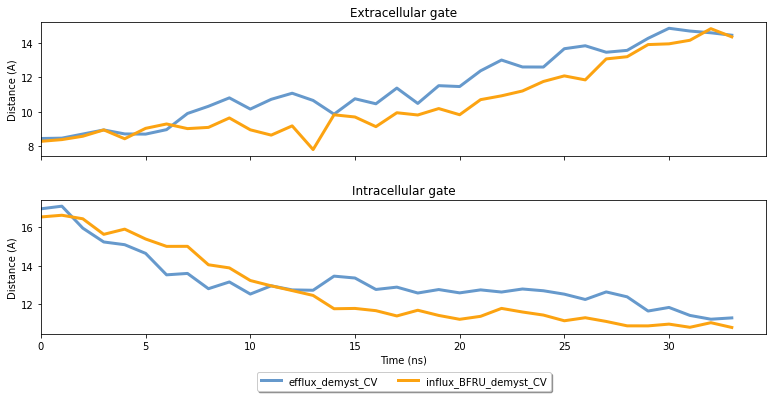

In [78]:
EC_dir = {}
IC_dir = {}

EC_list = []
IC_list = []
#colors = ['#6699CC', '#14213D', '#FCA311']
colors = ['#6699CC', '#FCA311']
for n, simulation in enumerate(universe_list):
    EC, IC = make_gate_arr(simulation, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])
    ### need to reverse the list for influx so that the gate dists will match efflux
    if traj_l[n].startswith('influx'):
        EC.reverse()
        IC.reverse()
        
    EC_dir[traj_l[n]] = EC
    IC_dir[traj_l[n]] = IC
    
    EC_list.append(EC)
    IC_list.append(IC)
    
make_gate_plot(EC_list = EC_list, IC_list= IC_list, label_list = traj_l)

Subtracting the gate dists

In [79]:
import pandas as pd
EC = pd.DataFrame(EC_dir)
IC = pd.DataFrame(IC_dir)
EC

,efflux_demyst_CV,influx_BFRU_demyst_CV
0,8.441935,8.277798
1,8.462727,8.378126
2,8.701039,8.573512
3,8.938792,8.941736
4,8.707100,8.427279
5,8.696666,9.031189
6,8.956370,9.284790
7,9.894346,9.015724
8,10.311277,9.086509
9,10.800194,9.634287


Make plots like GLUT5 atomistic KDE

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/MDAnalysis/core/selection.py:690: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(len(vals), dtype=np.bool)
No handles with labels found to put in legend.


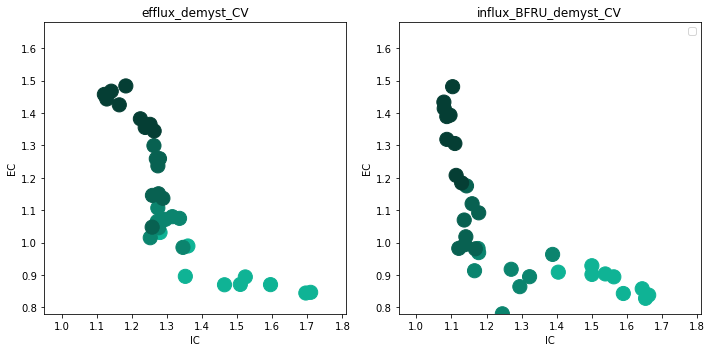

In [80]:
ax = ['ax1', 'ax2']
f, ax = plt.subplots(1,2, figsize = (10,5))
colors = np.empty([34], dtype="object")
colors[:9] = '#0FB395'
colors[9:17] = '#0B846E'
colors[17:25] = '#086151'
colors[25:] = '#053E34'

for n, simulation in enumerate(universe_list):
    EC, IC = make_gate_arr(simulation, gate_EC = [(30,37), (289,295)], gate_IC = [(136,145), (386,394)])
    if traj_l[n].startswith('influx'):
        EC.reverse()
        IC.reverse()
    EC = np.array(EC)
    IC = np.array(IC)
    ax[n].scatter(IC/10, EC/10, s = 200, color = colors)
    ax[n].set_xlim(0.95, 1.81)
    ax[n].set_ylim(0.78, 1.68)
    ax[n].set_title(traj_l[n])
    ax[n].set_xlabel('IC')
    ax[n].set_ylabel('EC')
    
plt.legend()
plt.tight_layout()
plt.savefig('../images_figs/confout_file_analysis/gate_scatter.iteration_%i.png' %iteration)

In [69]:
ls ..

cluster.log   clust-id.xvg    confout_files/  rmsd-dist.xvg
clusters.pdb  clust-size.xvg  rmsd-clust.xpm  scripts/
